In [1]:
import warnings
warnings.filterwarnings('ignore')
from models import ResNet18
#from torchvision.models import resnet18, resnet50
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image
import skimage 

import torch


# Loading the Model

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models

# 기존 ResNet18 모델 정의
class CustomResNet18(nn.Module):
    def __init__(self, in_channels=3, num_classes=8):
        super(CustomResNet18, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

model = CustomResNet18(in_channels=3, num_classes=2)

# 체크포인트 로드
checkpoint = torch.load('/home/bsc18/workspace/Hyunjin/ImageNet_output/tissuemnist/240527_164843/best_model.pth')

# 레이어 이름 변경 (예: 'fc' -> 'linear')
state_dict = checkpoint['net']
state_dict = {k.replace('fc', 'linear'): v for k, v in state_dict.items()}

# 모델 상태 사전 로드
model.load_state_dict(state_dict, strict=False)
model.eval()

print(model)


CustomResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [12]:
model = ResNet18(in_channels=3, num_classes=8)
checkpoint = torch.load('/home/bsc18/workspace/output/tissuemnist/240326_220538/best_model.pth')
model.load_state_dict(checkpoint['net'], strict=False)
model.eval()

print(model)

RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for conv1.weight: copying a param with shape torch.Size([64, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 3, 3, 3]).

# Loading the Image and GRAD-CAM

torch.Size([1, 3, 224, 224])


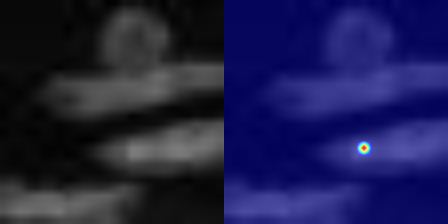

In [29]:
# image = cv2.imread('/home/bsc18/workspace/Hyojun/output/breastmnist/240426_231525/image_1_original.png', cv2.IMREAD_COLOR)
image = skimage.io.imread('/home/bsc18/workspace/Gyubin/output/tissuemnist/240527_182154/image_80_original.png')

#image_url = "/home/bsc18/workspace/Gyubin/Images/ADI-TCGA-AAICEQFN.tif"
#img = np.array(Image.open(requests.get(image_url, stream=True).raw))


img = cv2.resize(image, (224, 224))
img = np.float32(img) / 255
if len(img.shape) != 3: # grayscale image일 경우
    img = np.repeat(img[..., np.newaxis], 3, -1) # np.repeat 함수를 이용해 3차원의 형태로 변경

img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))

#input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
input_tensor = preprocess_image(img, mean=[.5], std=[.5])
print(input_tensor.shape)

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(6)]
target_layers = [model.layer4[-1]]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img) , cam_image))
Image.fromarray(images)
#  groundtruth ? --> index

In [8]:
a = skimage.io.imread('/home/bsc18/workspace/Hyojun/output/bloodmnist/240527_155533/image_2_original.png')
a

array([[[249, 214, 194],
        [244, 211, 192],
        [237, 205, 192],
        ...,
        [255, 224, 207],
        [255, 223, 209],
        [255, 223, 207]],

       [[246, 213, 194],
        [246, 213, 196],
        [241, 209, 194],
        ...,
        [255, 224, 205],
        [255, 223, 207],
        [255, 224, 205]],

       [[244, 211, 192],
        [246, 213, 196],
        [243, 211, 196],
        ...,
        [255, 225, 202],
        [255, 225, 204],
        [255, 225, 204]],

       ...,

       [[235, 203, 204],
        [245, 214, 211],
        [253, 223, 213],
        ...,
        [203, 172, 152],
        [206, 174, 159],
        [210, 176, 166]],

       [[230, 199, 196],
        [228, 197, 192],
        [225, 195, 184],
        ...,
        [223, 190, 171],
        [217, 184, 169],
        [212, 178, 166]],

       [[200, 169, 164],
        [194, 164, 156],
        [188, 158, 148],
        ...,
        [242, 209, 192],
        [230, 197, 182],
        [215, 181, 169]]

In [ ]:
a.shape

In [ ]:
list(a.keys())

In [ ]:
a["train_images"]

In [ ]:
a["train_images"][0].shape

In [ ]:
a["train_labels"][0]

In [ ]:
checkpoint = torch.load('/home/bsc18/workspace/Hyojun/output/breastmnist/240429_151617/best_model.pth')
checkpoint

In [ ]:
checkpoint['net'].keys()

In [ ]:
checkpoint.keys()

In [ ]:
model.load_state_dict(checkpoint['net'])


# Finding Labels


In [8]:
# l = np.load("/home/bsc18/workspace/Gyubin/Images/ADI-TCGA-AAICEQFN.tif")
l = np.load("/home/bsc18/workspace/Hyojun/.medmnist/tissuemnist.npz")
l

NpzFile '/home/bsc18/workspace/Hyojun/.medmnist/tissuemnist.npz' with keys: train_images, train_labels, val_images, val_labels, test_images...

In [9]:
l.keys()

KeysView(NpzFile '/home/bsc18/workspace/Hyojun/.medmnist/tissuemnist.npz' with keys: train_images, train_labels, val_images, val_labels, test_images...)

In [10]:
l['test_images'].shape

(47280, 28, 28)

In [15]:
l['test_labels'] [80:100]

array([[3],
       [0],
       [6],
       [0],
       [6],
       [6],
       [0],
       [0],
       [5],
       [3],
       [1],
       [6],
       [3],
       [1],
       [0],
       [6],
       [6],
       [6],
       [0],
       [0]], dtype=uint8)